In [27]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#! -------------------------------------------------------
os.environ['QES_BACKEND'] = 'numpy'   # Backend for numerical operations
os.environ['QES_LOGFILE'] = '0'       # Disable logging to file
#! -------------------------------------------------------

# add to directory
cwd             = Path(os.getcwd())
mod_path        = Path(os.curdir).resolve()
file_path       = mod_path.parent
qes_path        = file_path.parent.parent.parent.parent
data_path       = file_path.parent
qes_lib_path    = qes_path / "QES"
gen_lib_path    = qes_lib_path / "general_python"
print(f"-> CWD: {cwd}")
print(f"-> Module Path: {mod_path}")
print(f"-> File Path: {file_path}")
print(f"-> QES Path: {qes_path}")
print(f"-> QES Lib Path: {qes_lib_path}")
print(f"-> General Lib Path: {gen_lib_path}")
sys.path.insert(0, str(qes_path))
sys.path.insert(0, str(qes_lib_path))
sys.path.insert(0, str(gen_lib_path))

# --------------------------------------
from QES.general_python.common.plot import Plotter
from QES.general_python.common.directories import Directories
from QES.general_python.common.hdf5_lib import HDF5Handler
from QES.Algebra.hamil import Hamiltonian
from QES.Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
from QES.Algebra.Model.Noninteracting.plrb import PowerLawRandomBanded
# --------------------------------------
from QES.Algebra.Properties import statistical
from QES.general_python.physics import entropy
# --------------------------------------

typek           = "uniform"
model           = "um"

def repr(model: str, ns: int, param: float, **kwargs):
    if model == 'um' or model == 'ultrametric':
        return UltrametricModel.repr(ns=ns, n=kwargs.get('n', 1), J=kwargs.get('J', 1.0), g=kwargs.get('g', 1.0), alphas=param)
    elif model == 'plrb' or model == 'powerlaw':
        return PowerLawRandomBanded.repr(ns=ns, many_body=True, a=param, b=1.0)
    else:
        raise ValueError(f"Unknown model: {model}")
    
# --------------------------------------

stat_start      = "stat_"
diag_start      = "diag_"
fidl_start      = "fid_"
hist_start      = "hist_"
evol_start      = "evo_"
operator        = 'Sz/0'
# --------------------------------------
time_key        = '/time'
time_evo_key    = lambda operator: f'/time_evolution/{operator}/expectation'
time_evo_d_key  = lambda operator: f'/time_evolution/{operator}/diag_ens'
time_evo_e_key  = f'/time_evolution/quench/energy'
# --------------------------------------
energy_key      = '/energies'
ldos_key        = '/ldos'
vn_key          = '/entropy/quench/von_neumann/1.0'
tsalis_key      = '/entropy/quench/tsallis/2.0'
schmidt_gap_key = '/entropy/quench/schmidt_gap'
# --------------------------------------

f_fun_key       = lambda op: f'/histogram/{op}/average/values'
f_fun_full_key  = lambda op: f'/histogram/{op}/average/full/values'
k_fun_key       = f'/k_function/values'
k_fun_full_key  = f'/k_function/full/values'
k_f_key         = lambda op: f'/k_times_f/{op}/values'
k_f_full_key    = lambda op: f'/k_times_f/{op}/full/values'
k_f_mix_key     = lambda op: f'/k_times_f/{op}/mix/values'
s_fun_key       = lambda op: f'/s_function/{op}/values'
s_fun_full_key  = lambda op: f'/s_function/{op}/full/values'

om_key          = f'/histogram/edges'



-> CWD: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/um_evolotion/plot/august_2025
-> Module Path: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/um_evolotion/plot/august_2025
-> File Path: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/um_evolotion/plot
-> QES Path: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python
-> QES Lib Path: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/QES
-> General Lib Path: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/QES/general_python


In [28]:
def proces_data(data, key, throw_if_bad: bool = False) -> np.ndarray:
    data_in     = [x[key] for x in data]
    data_in     = [y for x in data_in for y in x if len(x) > 0] # flatten and remove empty arrays
    data_in     = np.array(data_in, dtype=float)
    if throw_if_bad and data_in.shape[0] == 0:
        raise Exception("No samples found...")
    return data_in

### Fluctuations

In [29]:


data_dir            = Directories(data_path / "data_big_times_test" / typek)
model_directories   = data_dir.list_dirs(as_string=True)
alphas              = [0.700, 0.800, 0.900]
nss                 = [8, 9, 10, 11, 12]

nss_alpha           = { alpha : [] for alpha in alphas }
sigma_ts            = { alpha : [] for alpha in alphas }
p2s                 = { alpha : [] for alpha in alphas }

# quick check of sigma_t
sigma_ts_init       = { alpha : [[] for _ in range(5)] for alpha in alphas }


for alpha in alphas:
    for ns in nss:
        hilbert_dim = 2**ns
        model_str   = repr(model=model, ns=ns, param=alpha, n=1)
        dir_in      = data_dir / model_str
        if not dir_in.exists():
            continue
        # evolution
        evo_files   = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: evol_start in str(x)])
        evo_data    = HDF5Manager.load_data_from_multiple_files(file_paths      = evo_files,
                                                                dataset_keys    = [time_key, time_evo_key(operator), time_evo_d_key(operator)],)
        evo_data_t  = proces_data(evo_data, time_key)
        evo_data_q  = proces_data(evo_data, time_evo_key(operator))

        # energies
        stat_files  = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: stat_start in str(x)])
        en_data     = HDF5Manager.load_data_from_multiple_files(file_paths      = stat_files,
                                                                dataset_keys    = [energy_key, ldos_key],)
        en_data_v               = proces_data(en_data, energy_key)
        differences             = np.diff(en_data_v, axis = 1)
        mean_lvl_spacing        = np.mean(differences, axis = 1) # mean level spacing over all samples
        heisenberg_time         = np.mean(2 * np.pi / mean_lvl_spacing)
        
        
        #! IPRS from the LDOS
        data_ldos               = proces_data(en_data, ldos_key)
        qs                      = [0.5, 1.0, 2.0, 3.0, 4.0] # divide by 2, as we have the LDOS, which is already squared - IPRS for quench
        iprs                    = { q: statistical.inverse_participation_ratio(data_ldos.T, q = q / 2) for q in qs }
        participation_entropies = { q: entropy.participation_entropy(data_ldos.T, q = q / 2) for q in qs }
        p2s[alpha].append(np.mean(iprs[2.0]))
        
        #! fluctuations        
        nss_alpha[alpha].append(ns)
        ts_start                = np.argmin(np.abs(heisenberg_time - evo_data_t))
        evo_data_cut            = evo_data_q[:, ts_start:]
        evo_data_cut_t          = evo_data_t[ts_start:]
        sigma_t                 = np.mean(np.var(evo_data_cut, axis = 1))
        sigma_ts[alpha].append(sigma_t)
        
        tstarts                 = [evo_data_t[0], heisenberg_time / 5, heisenberg_time / 2, heisenberg_time, 2*heisenberg_time]
        for it, tstart in enumerate(tstarts):
            ts_start                = np.argmin(np.abs(tstart - evo_data_t))
            evo_data_cut            = evo_data_q[:, ts_start:]
            evo_data_cut_t          = evo_data_t[ts_start:]
            sigma_t                 = np.mean(np.var(evo_data_cut, axis = 1))
            sigma_ts_init[alpha][it].append(sigma_t)
        
        

AxisError: axis 1 is out of bounds for array of dimension 1

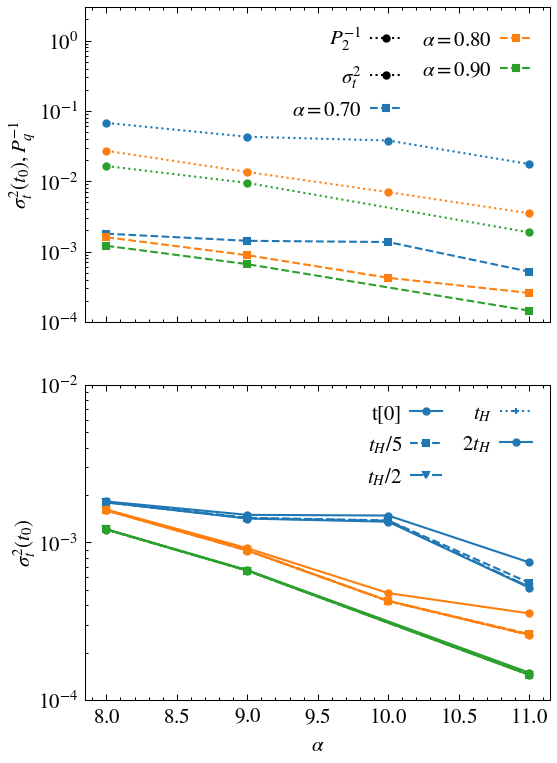

In [19]:
fig, ax = Plotter.get_subplots(nrows=2, ncols=1, sizex=4, sizey=6, dpi=150, sharex=True)

Plotter.plot(ax[0], [None], [None], ms = 3, ls = ':', lw = 1, marker = 'o', color = 'black', label = r'$P^{-1}_2$')
Plotter.plot(ax[0], [None], [None], ms = 3, ls = ':', lw = 1, marker = 'o', color = 'black', label = r'$\sigma_t^2$')
for ia, alpha in enumerate(alphas):
    # p2s
    Plotter.plot(ax[0], nss_alpha[alpha], p2s[alpha], ms = 3, ls = ':', lw = 1, marker = 'o', color = ia)
    Plotter.plot(ax[0], nss_alpha[alpha], sigma_ts[alpha], ms = 3,
                    ls      = '--', 
                    lw      = 1, marker = 's', color = ia,
                    label   = fr'$\alpha = {alpha:.2f}$')
    
    ######
    t0s = [r't[0]', r'$t_H/5$', r'$t_H/2$', r'$t_H$', r'$2t_H$']
    for iaa, values in enumerate(sigma_ts_init[alpha]):
        Plotter.plot(ax[1], nss_alpha[alpha], values, ms = 3,
                ls = iaa, lw = 1, marker = iaa, label = t0s[iaa], color = ia, labelcond=ia==0)
        
    
Plotter.set_legend(ax[0], ncols=2)
Plotter.set_legend(ax[1], ncols=2)
Plotter.set_ax_params(ax[0], which='y', yscale='log', ylim=(1e-4, 3e-0))
Plotter.set_ax_params(ax[1], which='y', yscale='log', ylim=(1e-4, 1e-2))
Plotter.set_ax_labels(ax[0], ylabel=r'$\sigma _t ^2 (t_0), P_q^{-1}$')
Plotter.set_ax_labels(ax[1], xlabel=r'$\alpha$', ylabel=r'$\sigma _t ^2 (t_0)$')


### f-functions, k-functions, s-functions - binned or not

['/Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/um_evolotion/data_big_times_test/uniform/Ultrametric(ns=8,N=1,J=1.0,g=1.0,a=0.700)/hist_9627.h5']
01_09_2025_09-35_01 [ERROR] Error reading dataset '<function <lambda> at 0x15f64eca0>': Accessing a group is done with bytes or str, not <class 'function'>
01_09_2025_09-35_01 [ERROR] Error reading dataset '<function <lambda> at 0x15e5bf560>': Accessing a group is done with bytes or str, not <class 'function'>
01_09_2025_09-35_01 [ERROR] Dataset key '/histogram/edges' not found in HDF5 file.
['/Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/um_evolotion/data_big_times_test/uniform/Ultrametric(ns=9,N=1,J=1.0,g=1.0,a=0.700)/hist_9627.h5']
01_09_2025_09-35_01 [ERROR] Error reading dataset '<function <lambda> at 0x15f64eca0>': Accessing a group is done with bytes or str, not <class 'function'>
01_09_2025_09-35_01 [ERROR] Error reading dataset '<function <lambda> at 0x15e5bf560>': Accessing a group is do

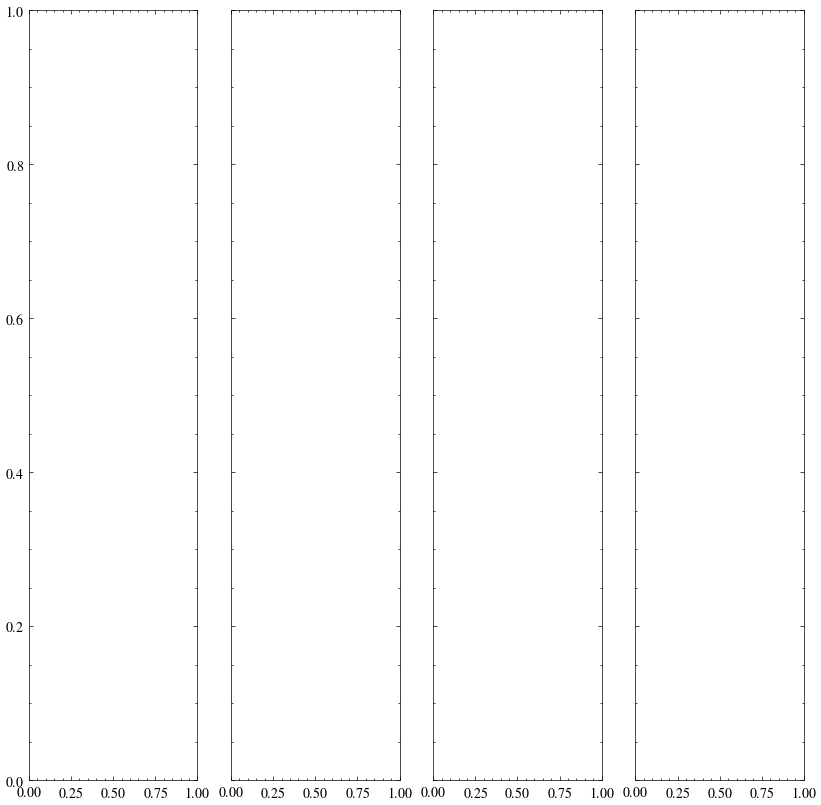

In [ ]:
from tracemalloc import Statistic
from common.hdf5man import HDF5Manager
from maths.statistics import Statistics


data_dir            = Directories(data_path / "data_big_times_test" / typek)
model_directories   = data_dir.list_dirs(as_string=True)
alphas              = [0.700]
nss                 = [8, 9, 10, 11]

fig, ax             = Plotter.get_subplots(nrows = 1, ncols = 4, sharey=True)

# quick check of sigma_t
bins                = { alpha : {} for alpha in alphas }

omegas              = { alpha : {} for alpha in alphas }
f_middle            = { alpha : {} for alpha in alphas }
f_full              = { alpha : {} for alpha in alphas }

k_full              = { alpha : {} for alpha in alphas }
k_middle            = { alpha : {} for alpha in alphas }

k_times_f_middle    = { alpha : {} for alpha in alphas }
k_times_f_mix       = { alpha : {} for alpha in alphas }
k_times_f_full      = { alpha : {} for alpha in alphas }

s_middle            = { alpha : {} for alpha in alphas }
s_full              = { alpha : {} for alpha in alphas }

s_fourier           = { alpha : {} for alpha in alphas }
s_omegas            = { alpha : {} for alpha in alphas }

for alpha in alphas:
    for ns in nss:
        hilbert_dim = 2**ns
        model_str   = repr(model=model, ns=ns, param=alpha, n=1)
        dir_in      = data_dir / model_str
        if not dir_in.exists():
            continue
        # evolution
        hist_files  = HDF5Handler.file_list_matching(directories = dir_in, 
                                                    conditions   = [lambda x: hist_start in str(x)])
        hist_data    = HDF5Manager.load_data_from_multiple_files(file_paths     = hist_files,
                                                                dataset_keys    = [f_fun_key, f_fun_full_key, om_key])
        
        